In [5]:
pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install ta

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.10.2-py3-none-any.whl size=29103 sha256=39c7de2d6beb48447c3116c087a874c45d5c13297874d52c8f1fe91d9d58256c
  Stored in directory: /root/.cache/pip/wheels/47/51/06/380dc516ea78621870b93ff65527c251afdfdc5fa9d7f4d248
Successfully built ta


In [7]:
import yfinance as yfin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import ta

In [31]:
#Descargamos los datos de Ethereum
df = yfin.download("ETH-USD", start="2019-09-01", end="2021-09-01")
#Retornos aritmeticos
df["Close t-1"] = df["Close"].shift(1) #shift desplaza filas
df["Retornos"] = (df["Close"] - df["Close t-1"])/df["Close t-1"]
#Retornos logaritmicos
df["Log Returns"] = np.log(df["Close"]) - np.log(df["Close t-1"]) 

[*********************100%***********************]  1 of 1 completed


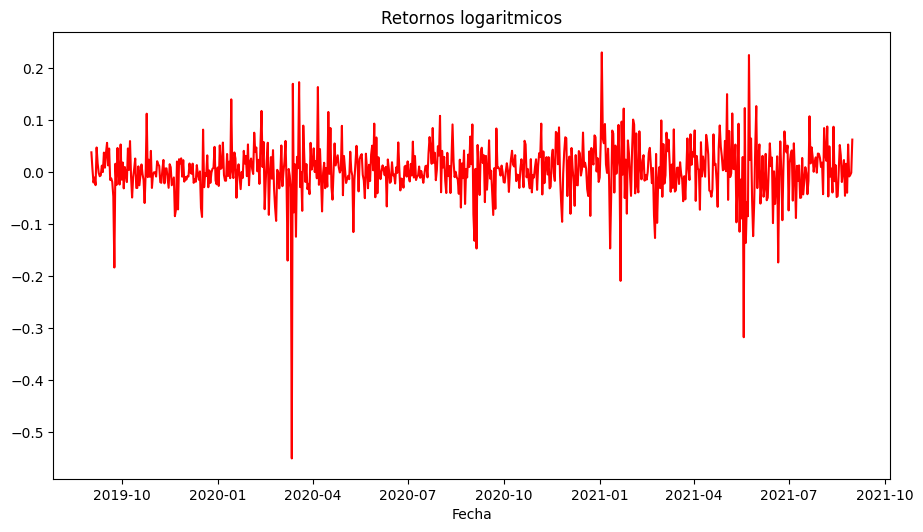

In [10]:
#Graficar retornos
plt.figure(figsize=(10.8, 5.8))
plt.plot(df["Log Returns"], color = "red")
plt.title("Retornos logaritmicos")
plt.xlabel("Fecha")
plt.show()

In [33]:
#Retorno diario
ret_d = np.mean(df["Log Returns"])
#Retorno anual de la forma ret_d*252
ret_a = ret_d*252
ret_a

1.0342582419921265

In [32]:
#volatilidad diaria S&P500
vol_d = np.std(df["Log Returns"])
#Calculamos la volatilidad diaria anualizada (252 dias bursatiles)
vol_a = vol_d*np.sqrt(252)
vol_a

0.8465930452865625

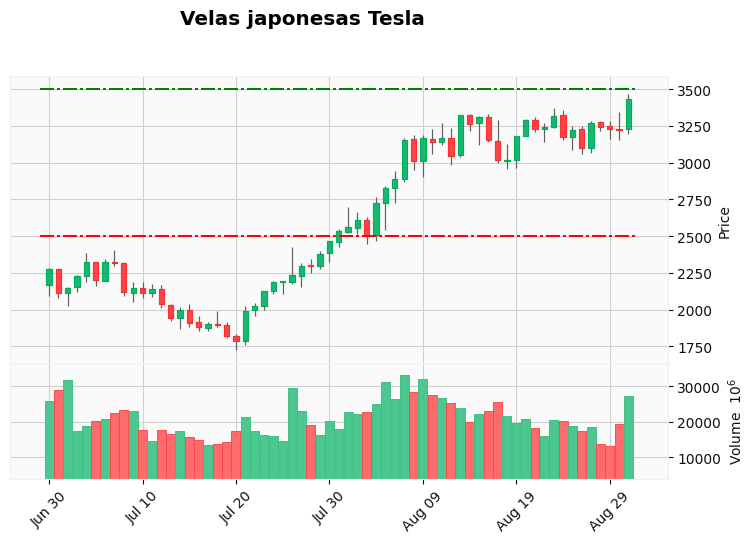

In [14]:
from matplotlib import colors
#Diagrama de velas japonesas, incluimos libreria mplfinance y la importamos
mpf.plot(df[-63:], #para graficar los ultimos 2 meses
         hlines=dict(hlines=[2500, 3500], colors=["red", "green"], linestyle="-."),
         type="candle",
         volume=True,
         figratio=(10.8, 6.8),
         style= "yahoo",
         title="Velas japonesas Tesla"
)

In [15]:
#Comparar ETH-USD con un portafolio de mercado (S&P500)
#Dascargar datos de S&P500
df2 = yfin. download("^GSPC", start="2019-09-01", end="2021-09-01")

[*********************100%***********************]  1 of 1 completed


In [16]:
#Si deseamos comparar la inversion en cada activo, no podriamos ya que las magnitudes son distintas
#Escalar las series a un valor de 100$ (invertir 100$ y cuanto tendria en un tiempo determinado)
df["Close_100"] = (100/df["Close"][0])*df["Close"] #[0] para multiplicarlo con la primera entrada
df2["Close_100"] = (100/df2["Close"][0])*df2["Close"]

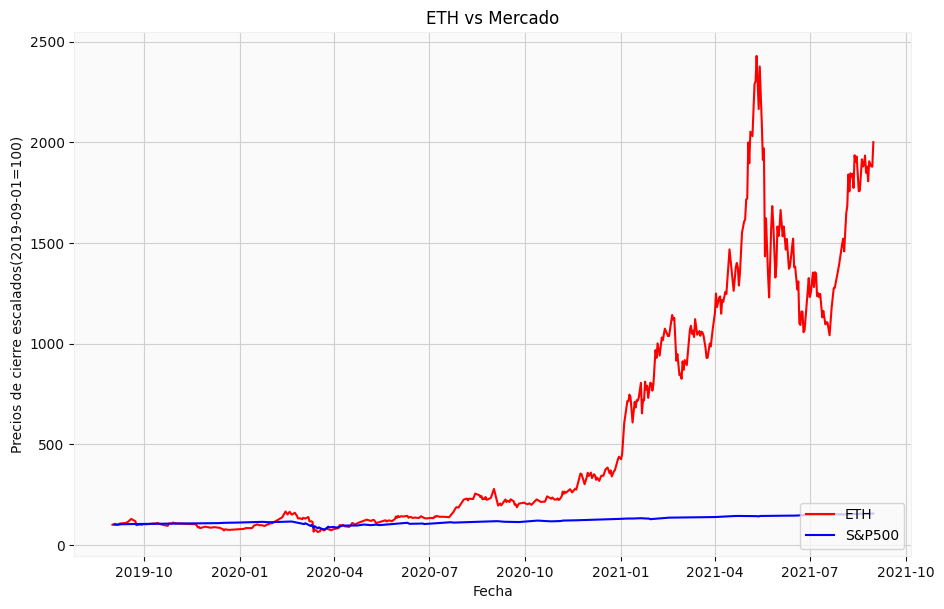

In [17]:
#Graficamos las series ajustadas a 100$
plt.figure(figsize=(10.8, 6.8))
plt.title("ETH vs Mercado")
plt.xlabel("Fecha")
plt.ylabel("Precios de cierre escalados(2019-09-01=100)")
plt.plot(df["Close_100"], color="red")
plt.plot(df2["Close_100"], color="blue")
plt.legend(["ETH", "S&P500"], loc="lower right")
plt.show()

In [24]:
#Calculamos las MA exponencial
#EMA 5 dias (corta)
df["EMA_5"] = df["Close"].ewm(span=5, adjust=False).mean()
#EMA 20 dias (larga)
df["EMA_20"] = df["Close"].ewm(span=20, adjust=False).mean()
#EMA 5 dias (corta)
df["EMA_50"] = df["Close"].ewm(span=50, adjust=False).mean()
#EMA 20 dias (larga)
df["EMA_100"] = df["Close"].ewm(span=100, adjust=False).mean()

In [25]:
#Implementamos las señales de compra y venta
#Calculamos el numero de datos
N =len(df)

#Lista de señalas
# -1 si vamos a vender; 0 si vamos a mantener; 1 si vamos a comprar
signals = [0] #0 suponemos que para el primer dia mantenemos posicion
for i in range(1, N): #indice comienza en 1 (el primer dato no tiene dia anterior)
  short = df["EMA_5"][i]
  long = df["EMA_20"][i]
  #ahora nos preguntamos si para el dia i las EMA se cruzan
  p_short = df["EMA_5"][i-1]
  p_long = df["EMA_20"][i-1]
  #para señal de compra
  if p_short < p_long and short >= long:
    signals.append(1)
  #para señal de venta
  elif p_short > p_long and short <= long:
    signals.append(-1)
  else:
    signals.append(0)

df["Signals"] = signals

In [26]:
#Calculamos las posiciones donde iran los triangulos nos indican las señales
df["Buy"] = np.where(df["Signals"]==1, df["Close"], np.nan)
df["Sell"] = np.where(df["Signals"]==-1, df["Close"], np.nan)

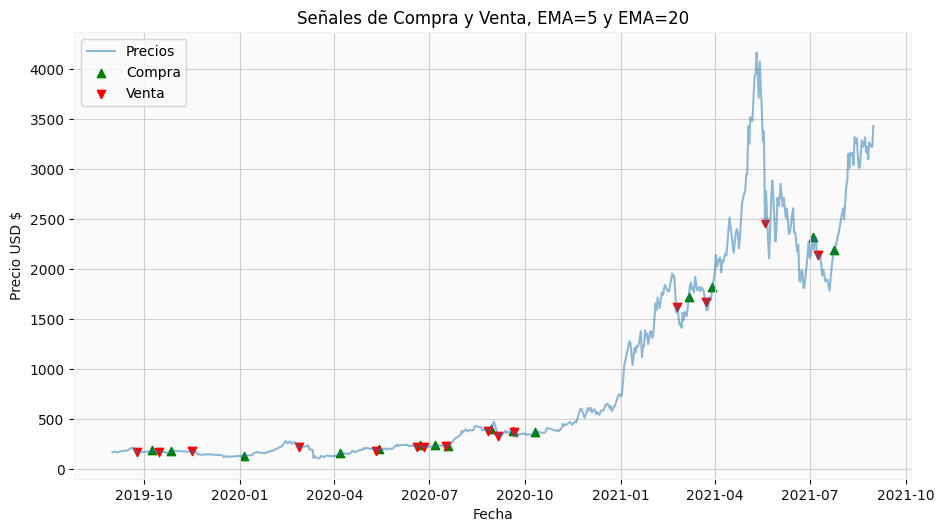

In [27]:
plt.figure(figsize=(10.8, 5.8))
plt.title("Señales de Compra y Venta, EMA=5 y EMA=20")
plt.plot(df["Close"], alpha=0.5, label="Precios")
plt.scatter(df.index, df["Buy"], color="green", marker="^", label="Compra")
plt.scatter(df.index, df["Sell"], color="red", marker="v", label="Venta")
plt.xlabel("Fecha")
plt.ylabel("Precio USD $")
plt.legend(loc ="upper left")
plt.show()